# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

https://medium.com/@naomi.fridman/install-pyspark-to-run-on-jupyter-notebook-on-windows-4ec2009de21f

In [303]:
#import pyspark
import findspark

import pyspark.sql.functions as F

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType

from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

from handyspark import *

In [191]:
import datetime
import time

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [192]:
findspark.init()
findspark.find()


'C:\\spark\\spark-2.4.5-bin-hadoop2.7'

In [193]:
# create a Spark session
spark = (SparkSession 
    .builder 
    .appName("Sparkify Project") 
    .getOrCreate()) 

In [194]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [195]:
sparkifyDF = spark.read.json("data/mini_sparkify_event_data.json")

## Overview

Summary about mini sparkify dataset and comments from exploring the data:

* `286500` rows
* `18` columns
* `8346` have no values for userId and most of the other columns are also null. It occurs when authentication level in the auth column is either Guest of Logged Out. These rows are dropped from the dataset.
* there is no duplicates in the medium size dataset
* There is no empty sessionId values.
* logs have been gathered from `1st October 2018 (02:00:11)` to `3rd of December 2018 (02:11:16)`
* users registrations are from `18th of March 2017` to `26th of November 2018`.
* ts and registration columns have been converted from unix time to datetime
* hour and day of the month was extracted from the ts (time) column
* `225` unique users
* `2312` unique sessions
* churn was defined when page was logged as 'Cancellation Confirmation' interaction
* `23 %` of the users have churned - it is not a balanced dataset.

In [196]:
sparkifyDF.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [197]:
num_rows = sparkifyDF.count()

f"In the dataset there is {num_rows} rows and {len(sparkifyDF.columns)} columns"

'In the dataset there is 286500 rows and 18 columns'

Columns that describe a user

 * `firstName`: string - first name of a user 
 * `gender` string - gender of a user
 * `lastName`: string - last name of a user
 * `location`: string - location of a user
 * `registration`: long - timestamp of when a user registered to sparkify service
 * `userAgent`: string - agent which the user user for accessing sparkify service
 * `userId`: string - identifier of a user
 * `level`: string - describes if user is on a free or paid subscription level. Keep in mind that a user can both be free and paid as the time progresses, i.e. it is not as static as the other columns above.


In [198]:
sparkifyDF.select("userId", "firstName", "lastName", "gender", "location", "registration", "userAgent", "level").show(10)

+------+---------+--------+------+--------------------+-------------+--------------------+-----+
|userId|firstName|lastName|gender|            location| registration|           userAgent|level|
+------+---------+--------+------+--------------------+-------------+--------------------+-----+
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|Mozilla/5.0 (Wind...| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|1538331630000|"Mozilla/5.0 (Win...| free|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|Mozilla/5.0 (Wind...| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|1538331630000|"Mozilla/5.0 (Win...| free|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|Mozilla/5.0 (Wind...| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|1538331630000|"Mozilla/5.0 (Win...| free|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|1538331630000|"Mozilla/5.0 (Win...| free|
|    30|    Colin| Freeman|   

Columns that describe how a user interacts with the sparkify service:


* `auth: string` - cathegories of the authentication. It can be either of the 4: Logged in, Logged out, Cancelled and Guest
* `itemInSession`: long - count of logs per session
* `method`: string - method for an http request, it is either GET or PUT method type.
* `page`: string - this column describes a category of an interaction for a log. 22 categories (Canel, Submit Downgrade, Thumbs Down, Home,...)
* `sessionId`: long - id of a session where the log occured
* `status`: long - status code of a http response, there are three categories in the dataset (200 - OK, 307 - temporary redirect, 404 - Not Found )
* `ts`: long - log's timestamp



In [199]:
sparkifyDF.select("auth", "itemInSession", "method", "page", "sessionId", "status", "ts").show(10)

+---------+-------------+------+---------------+---------+------+-------------+
|     auth|itemInSession|method|           page|sessionId|status|           ts|
+---------+-------------+------+---------------+---------+------+-------------+
|Logged In|           50|   PUT|       NextSong|       29|   200|1538352117000|
|Logged In|           79|   PUT|       NextSong|        8|   200|1538352180000|
|Logged In|           51|   PUT|       NextSong|       29|   200|1538352394000|
|Logged In|           80|   PUT|       NextSong|        8|   200|1538352416000|
|Logged In|           52|   PUT|       NextSong|       29|   200|1538352676000|
|Logged In|           81|   PUT|       NextSong|        8|   200|1538352678000|
|Logged In|           82|   PUT|       NextSong|        8|   200|1538352886000|
|Logged In|           53|   PUT|       NextSong|       29|   200|1538352899000|
|Logged In|           54|   PUT|Add to Playlist|       29|   200|1538352905000|
|Logged In|           55|   PUT|       N

Columns that describe song level information:

* `artist`: string - name of the artist
* `song`: string - name of the song
* `length`: double - length of the song in seconds

In [200]:
sparkifyDF.select("song", "artist", "length").show(10)

+--------------------+--------------------+---------+
|                song|              artist|   length|
+--------------------+--------------------+---------+
|           Rockpools|      Martha Tilston|277.89016|
|              Canada|    Five Iron Frenzy|236.09424|
|   Time For Miracles|        Adam Lambert| 282.8273|
|Knocking On Forbi...|              Enigma|262.71302|
|Harder Better Fas...|           Daft Punk|223.60771|
|      Don't Leave Me|The All-American ...|208.29995|
|         Run Run Run|The Velvet Underg...|260.46649|
|Passengers (Old A...|        Starflyer 59|185.44281|
|                null|                null|     null|
|          Fuck Kitty|            Frumpies|134.47791|
+--------------------+--------------------+---------+
only showing top 10 rows



In [201]:
for col in sparkifyDF.columns:
    sparkifyDF.describe([col]).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201141085|
|    min|                 0|
|    max| 

## check sessionId and userId for null values and empty strings

In [202]:
sessionId_null_count = sparkifyDF.filter(sparkifyDF["sessionId"].isNull()).count()
sessionId_empty_count = sparkifyDF.filter(sparkifyDF["sessionId"] == "").count()
userId_null_count = sparkifyDF.filter(sparkifyDF["userId"].isNull()).count()
userId_empty_count = sparkifyDF.filter(sparkifyDF["userId"] == "").count()


print(f" Dataset has: \n {sessionId_null_count} sessionId null values \n {sessionId_empty_count} sessionId empty string values \n {userId_null_count} userId null values \n {userId_empty_count} sessionId empty string values.")

print(f" \n There is no duplicated rows in the data ({sparkifyDF.dropDuplicates().count() == sparkifyDF.count()})")

Dataset has: 
 0 sessionId null values 
 0 sessionId empty string values 
 0 userId null values 
 8346 sessionId empty string values.
 
 There is no duplicated rows in the data (True)


When userId has empty string, it corresponds to the `auth` column being either `Logged Out` or `Guest` values.

In [203]:
sparkifyDF.filter(sparkifyDF["userId"] == "").select("auth").distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



## Drop if userId is an empty string

In [204]:
sparkifyDF = sparkifyDF.filter(sparkifyDF["userId"] != "")

## Check and fix ts  and registration columns

In [205]:
(sparkifyDF
    .select("ts")
    .show(2)
    )

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
+-------------+
only showing top 2 rows



In [206]:
convert_date = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

sparkifyDF = (
    sparkifyDF
        .withColumn("time", convert_date(sparkifyDF.ts))
        .withColumn("time", to_timestamp("time"))
        .withColumn("registration_time", convert_date(sparkifyDF.registration))
        .withColumn("registration_time",to_timestamp("registration_time"))
)

In [207]:
sparkifyDF.select("ts", "time", "registration", "registration_time").show(3)

+-------------+-------------------+-------------+-------------------+
|           ts|               time| registration|  registration_time|
+-------------+-------------------+-------------+-------------------+
|1538352117000|2018-10-01 02:01:57|1538173362000|2018-09-29 00:22:42|
|1538352180000|2018-10-01 02:03:00|1538331630000|2018-09-30 20:20:30|
|1538352394000|2018-10-01 02:06:34|1538173362000|2018-09-29 00:22:42|
+-------------+-------------------+-------------+-------------------+
only showing top 3 rows



## Range of the time and registration columns

In [208]:
sparkifyDF.select(F.min("time")).show(), sparkifyDF.select(F.max("time")).show()

+-------------------+
|          min(time)|
+-------------------+
|2018-10-01 02:01:57|
+-------------------+

+-------------------+
|          max(time)|
+-------------------+
|2018-12-03 02:11:16|
+-------------------+



(None, None)

In [209]:
sparkifyDF.select(F.min("registration_time")).show(), sparkifyDF.select(F.max("registration_time")).show()

+----------------------+
|min(registration_time)|
+----------------------+
|   2018-03-18 14:44:35|
+----------------------+

+----------------------+
|max(registration_time)|
+----------------------+
|   2018-11-26 16:49:14|
+----------------------+



(None, None)

## Extract hour and day of the month, from time column (not used in the current version for feature engineering)

In [210]:
sparkifyDF = (sparkifyDF
    .withColumn('hour', F.hour(sparkifyDF.time))
    .withColumn('dayofmonth', F.dayofmonth(sparkifyDF.time))
)

In [211]:
sparkifyDF.select("ts", "time", "dayofmonth" , "hour").show(3)

+-------------+-------------------+----------+----+
|           ts|               time|dayofmonth|hour|
+-------------+-------------------+----------+----+
|1538352117000|2018-10-01 02:01:57|         1|   2|
|1538352180000|2018-10-01 02:03:00|         1|   2|
|1538352394000|2018-10-01 02:06:34|         1|   2|
+-------------+-------------------+----------+----+
only showing top 3 rows



## Page column

In [212]:
sparkifyDF.select("page").distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [213]:
sparkifyDF.filter(sparkifyDF["page"].isNull()).count(), sparkifyDF.filter(sparkifyDF["page"] == "").count()

(0, 0)

## Gender column

In [214]:
sparkifyDF.filter(sparkifyDF["gender"].isNull()).count(), sparkifyDF.filter(sparkifyDF["gender"] == "").count()

(0, 0)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Preliminary Analysis

In [182]:
#hdf = sparkifyDF.toHandy() 

In [215]:
unique_users_count = sparkifyDF.select("userId").distinct().count()
unique_session_count = sparkifyDF.select("sessionId").distinct().count()

print(f"There is {unique_users_count} unique userId's in the data. \nThere is {unique_session_count} unique sessionId's in the data.")

There is 225 unique userId's in the data. 
There is 2312 unique sessionId's in the data.


## Summary stats for numeric columns

In [216]:
numerical_columns = ["sessionId", "itemInSession", "registration", "status", "time", "length"]
sparkifyDF.select(numerical_columns).describe().show()

+-------+------------------+------------------+--------------------+------------------+------------------+
|summary|         sessionId|     itemInSession|        registration|            status|            length|
+-------+------------------+------------------+--------------------+------------------+------------------+
|  count|            278154|            278154|              278154|            278154|            228108|
|   mean|1042.5616241362698|114.89918174824018|1.535358834085557E12|209.10321620397335|249.11718197783722|
| stddev| 726.5010362219821|129.85172939949013| 3.291321616328068E9|30.151388851327823| 99.23517921058324|
|    min|                 1|                 0|       1521380675000|               200|           0.78322|
|    max|              2474|              1321|       1543247354000|               404|        3024.66567|
+-------+------------------+------------------+--------------------+------------------+------------------+



## Inspect value counts of categoric columns

In [217]:
# helper function for value counts and percentages.

def pandas_cat_percent(df, column, distinct=False):
   
     if distinct == False:
          df  = (df
               .groupBy(column)
               .count()
               .withColumn('percentage', F.round(F.col('count') / F.sum('count').over(Window.partitionBy()), 3))
               .sort(F.desc("percentage"))
               .show()
          )
     else:
          df  = (df
               .select("userId", column)
               .distinct()
               .groupBy(column)
               .count()
               .withColumn('percentage', F.round(F.col('count') / F.sum('count').over(Window.partitionBy()), 3))
               .sort(F.desc("percentage"))
               .show()
          )
      
     return df   

In [218]:
pandas_cat_percent(sparkifyDF, "gender", distinct=True)

+------+-----+----------+
|gender|count|percentage|
+------+-----+----------+
|     M|  121|     0.538|
|     F|  104|     0.462|
+------+-----+----------+



In [219]:
pandas_cat_percent(sparkifyDF, "level", distinct=True)

+-----+-----+----------+
|level|count|percentage|
+-----+-----+----------+
| free|  195|     0.542|
| paid|  165|     0.458|
+-----+-----+----------+



In [220]:
pandas_cat_percent(sparkifyDF, "page")

+--------------------+------+----------+
|                page| count|percentage|
+--------------------+------+----------+
|            NextSong|228108|      0.82|
|           Thumbs Up| 12551|     0.045|
|                Home| 10082|     0.036|
|     Add to Playlist|  6526|     0.023|
|          Add Friend|  4277|     0.015|
|         Roll Advert|  3933|     0.014|
|              Logout|  3226|     0.012|
|         Thumbs Down|  2546|     0.009|
|           Downgrade|  2055|     0.007|
|            Settings|  1514|     0.005|
|                Help|  1454|     0.005|
|               About|   495|     0.002|
|             Upgrade|   499|     0.002|
|               Error|   252|     0.001|
|       Save Settings|   310|     0.001|
|      Submit Upgrade|   159|     0.001|
|              Cancel|    52|       0.0|
|    Submit Downgrade|    63|       0.0|
|Cancellation Conf...|    52|       0.0|
+--------------------+------+----------+



In [221]:
list(map(lambda x: x[0], sparkifyDF.select("page").distinct().collect()))

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [222]:
pandas_cat_percent(sparkifyDF, "status")

+------+------+----------+
|status| count|percentage|
+------+------+----------+
|   200|254718|     0.916|
|   307| 23184|     0.083|
|   404|   252|     0.001|
+------+------+----------+



In [223]:
pandas_cat_percent(sparkifyDF, "userAgent")

+--------------------+-----+----------+
|           userAgent|count|percentage|
+--------------------+-----+----------+
|"Mozilla/5.0 (Win...|22751|     0.082|
|"Mozilla/5.0 (Mac...|19611|     0.071|
|"Mozilla/5.0 (Mac...|18448|     0.066|
|"Mozilla/5.0 (Mac...|17348|     0.062|
|Mozilla/5.0 (Wind...|16700|      0.06|
|"Mozilla/5.0 (Win...|15395|     0.055|
|"Mozilla/5.0 (Win...|14598|     0.052|
|Mozilla/5.0 (Maci...|10300|     0.037|
|"Mozilla/5.0 (iPa...| 8912|     0.032|
|Mozilla/5.0 (comp...| 8624|     0.031|
|"Mozilla/5.0 (Mac...| 8094|     0.029|
|"Mozilla/5.0 (Win...| 7923|     0.028|
|"Mozilla/5.0 (Mac...| 7906|     0.028|
|"Mozilla/5.0 (Win...| 7624|     0.027|
|"Mozilla/5.0 (iPh...| 6417|     0.023|
|Mozilla/5.0 (Wind...| 5989|     0.022|
|"Mozilla/5.0 (Mac...| 5716|     0.021|
|"Mozilla/5.0 (Win...| 5238|     0.019|
|"Mozilla/5.0 (Win...| 4917|     0.018|
|Mozilla/5.0 (Wind...| 4663|     0.017|
+--------------------+-----+----------+
only showing top 20 rows



## Define churn flag

In [224]:
sparkifyDF = sparkifyDF.withColumn("churn", F.when(F.col("page") == 'Cancellation Confirmation', 1).otherwise(0))

In [233]:
user_churn_count = (sparkifyDF
    .groupBy("userId")
    .agg({"churn" : "sum"})
    .sort(F.desc("sum(churn)"))
    .select(F.avg("sum(churn)")).collect()
    )

print(f"In total, {round(user_churn_count[0][0]*100, 0)} percent of users have churned.")

In total, 23.0 percent of users have churned.


In [234]:
sparkifyDF.select("churn").distinct().show()

+-----+
|churn|
+-----+
|    1|
|    0|
+-----+



In [237]:
#sparkifyDF.filter(sparkifyDF.length.isNotNull()).groupby("churn").avg("length").show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [57]:
sparkifyDF.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- registration_time: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- dayofmonth: integer (nullable = true)
 |-- churn: integer (nullable = false)
 |-- churn_helper: string (nullable = false)



## User churn table

In [239]:
users_churn = sparkifyDF.select(['userId', 'churn']).distinct()

In [240]:
window = Window.partitionBy(users_churn['userId']).orderBy("userId", F.desc("churn"))

In [241]:
users_churn = users_churn.withColumn("rank", F.rank().over(window))
users_churn = users_churn.filter(users_churn.rank == 1).select("userId", "churn")

In [242]:
users_churn.groupBy("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



## Artist and songs count - features

In [245]:
artist_count = (sparkifyDF
    .select("userId", "artist")
    .distinct()
    .groupby("userId")
    .count()
    .withColumnRenamed('count', 'artist_count')
    )

songs_count = (sparkifyDF
    .select("userId", "song")
    .distinct()
    .groupby("userId")
    .count()
    .withColumnRenamed('count', 'song_count')
)   

## Friends, thumbs up, thumbs down and error count - features

In [79]:
friends_count = (sparkifyDF
        .filter(sparkifyDF.page=='Add Friend')
        .select('userId', 'page')
        .groupBy('userId')
        .count()
        .withColumnRenamed('count', 'friends_count')
        )

thumbs_up_count = (sparkifyDF
        .filter(sparkifyDF.page=='Thumbs Up')
        .select('userId', 'page')
        .groupBy('userId')
        .count()
        .withColumnRenamed('count', 'thumbs_up_count')
        )
    
thumbs_down_count = (sparkifyDF
        .filter(sparkifyDF.page=='Thumbs Down')
        .select('userId', 'page')
        .groupBy('userId')
        .count()
        .withColumnRenamed('count', 'thumbs_down_count')
        )

error_count = (sparkifyDF
        .filter(sparkifyDF.page=='Error')
        .select('userId', 'page')
        .groupBy('userId')
        .count()
        .withColumnRenamed('count', 'error_count')
        )

## User gender feature

In [125]:
user_gender = (sparkifyDF
    .select("userId", "gender")
    .distinct()
    .withColumn("gender", F.when(F.col("gender") == 'M', 1).otherwise(0))
)

## Average session time per user - feature

In [257]:
session_time = (sparkifyDF
    .select("userId", "sessionId", "time")
    .sort(F.desc("sessionId"),F.asc("time"))
    .groupBy("userId", "sessionId")
    .agg(F.min(sparkifyDF.time).alias("time_min"), F.max(sparkifyDF.time).alias("time_max"))
    
)

session_time = session_time.withColumn("session_time_diff", (F.unix_timestamp(session_time.time_max) -  F.unix_timestamp(session_time.time_min))/60)

session_time_mean = session_time.groupBy("userId").agg(F.round(F.mean(session_time.session_time_diff), 0).alias("session_time_mean"))

## Merge all the calculated feature dataframes with users dataframe on `userId`

In [258]:
df_merged = (users_churn
        .join(friends_count, on='userId')
        .join(thumbs_up_count, on='userId')
        .join(thumbs_down_count, on='userId')
        .join(error_count, on='userId')
        .join(artist_count, on='userId')
        .join(songs_count, on='userId')
        .join(user_gender, on='userId')
        .join(session_time_mean, on='userId')
)

In [259]:
%%time
df_merged.show(5)

+------+-----+-------------+---------------+-----------------+-----------+------------+----------+------+-----------------+
|userId|churn|friends_count|thumbs_up_count|thumbs_down_count|error_count|artist_count|song_count|gender|session_time_mean|
+------+-----+-------------+---------------+-----------------+-----------+------------+----------+------+-----------------+
|   124|    0|           74|            171|               41|          6|        2233|      3340|     0|            579.0|
|    51|    1|           28|            100|               21|          1|        1386|      1855|     1|            872.0|
|     7|    0|            1|              7|                1|          1|         143|       149|     1|             88.0|
|    15|    0|           31|             81|               14|          2|        1303|      1708|     1|            528.0|
|    54|    1|           33|            163|               29|          1|        1745|      2415|     0|            322.0|
+------+

## Number of users with the neccessary features have reduced from 225 to 115.

In [87]:
df_merged.count()

115

## Convert to pandas dataframe for plotting

In [260]:
%%time
df_merged_pandas = df_merged.toPandas()

Wall time: 42.6 s


In [261]:
df_merged_pandas.head()

,userId,churn,friends_count,thumbs_up_count,thumbs_down_count,error_count,artist_count,song_count,gender,session_time_mean
0,124,0,74,171,41,6,2233,3340,0,579.0
1,51,1,28,100,21,1,1386,1855,1,872.0
2,7,0,1,7,1,1,143,149,1,88.0
3,15,0,31,81,14,2,1303,1708,1,528.0
4,54,1,33,163,29,1,1745,2415,0,322.0


## Churn vs gender

Wall time: 49 ms


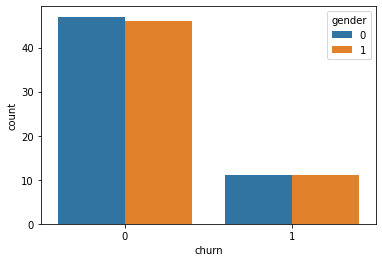

In [263]:
%%time
import seaborn as sns

sns.countplot(
    x = "churn",
    hue = "gender",
    data=df_merged_pandas
    )

## Pairplot  of all features hued on churn column

Wall time: 9.33 s


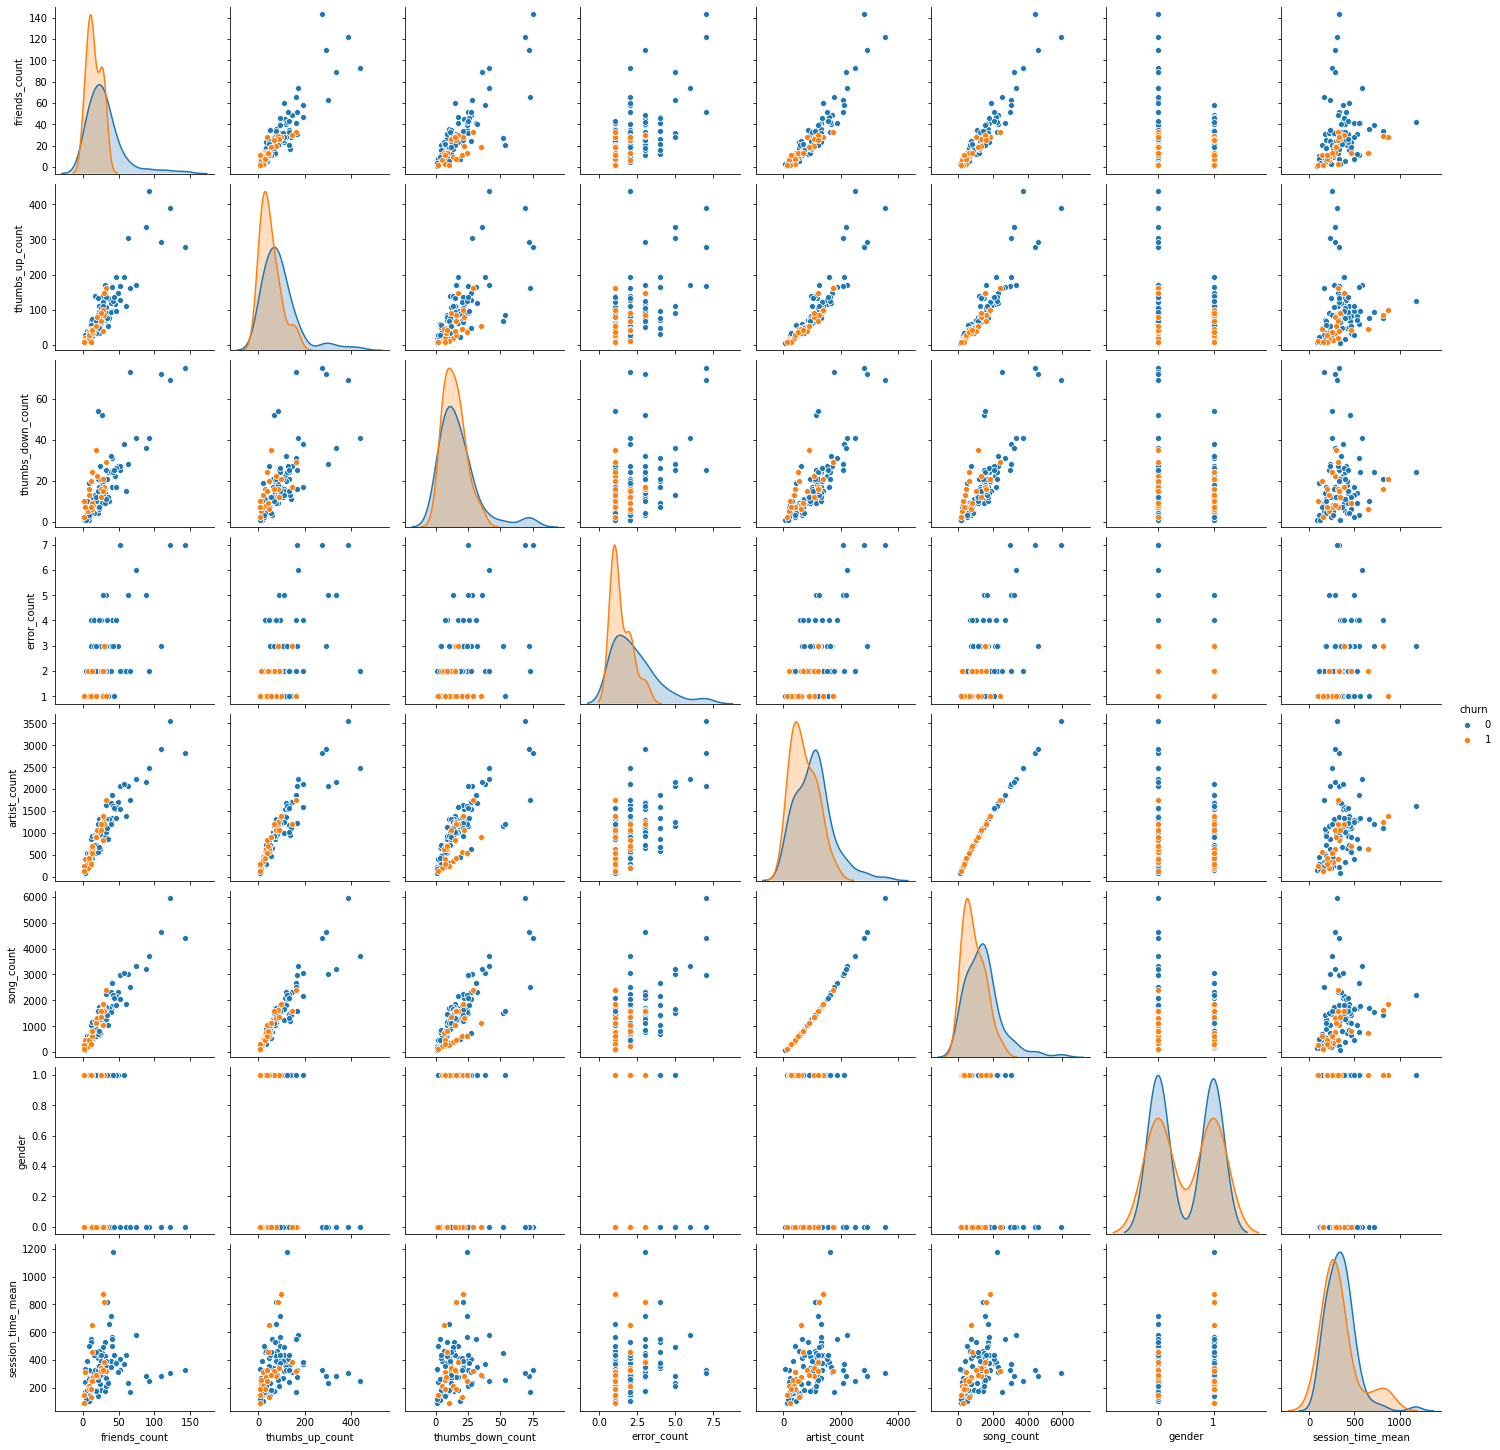

In [268]:
%%time

sns.pairplot(df_merged_pandas.iloc[:,1:], hue="churn");

## Any correlation between features?

Wall time: 106 ms


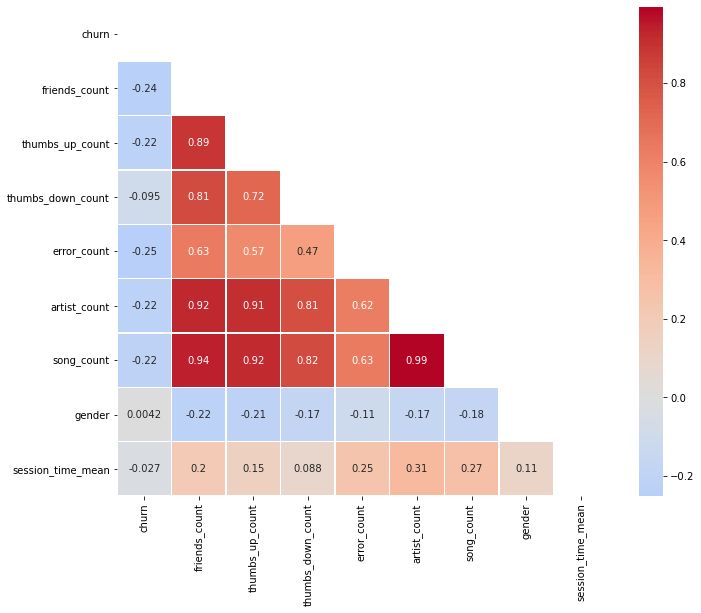

In [266]:
%%time

corr = df_merged_pandas.iloc[:,1:].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, annot = True, center= 0, cmap= 'coolwarm', linewidths=.5)


In [270]:
upper  = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

['artist_count', 'song_count']

## Drop artist_count due to colinearity.

From the correlation matrix we can see there are colinearity between the features. I decided to drop one of the features that are colinear and have correlation factor larger than 0.9 which is artist_count

In [271]:
df_merged = df_merged.drop("artist_count")

## export merged df to json 

In [272]:
df_merged_pandas.to_csv("data/df_merged_pandas.csv", index=False)
df_merged_pandas = pd.read_csv("data/df_merged_pandas.csv",index_col=None)

In [273]:
df_merged = spark.createDataFrame(df_merged_pandas)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [274]:
df_merged.columns

['userId',
 'churn',
 'friends_count',
 'thumbs_up_count',
 'thumbs_down_count',
 'error_count',
 'artist_count',
 'song_count',
 'gender',
 'session_time_mean']

feature dataset summary:

* 6 numerical features - 
     'friends_count',
    'thumbs_up_count',
    'thumbs_down_count',
     'error_count',
     'song_count',
     'session_time_mean'
     
* 1 binary feature -
     'gender'


## Split data to train and test

In [279]:
train, test = df_merged.randomSplit([0.7, 0.3], seed=47)

In [280]:
train.count(), test.count()

(71, 44)

## Transformation pipeline

In [278]:
numeric_columns = ["friends_count", "thumbs_up_count", "thumbs_down_count", "error_count", "song_count", "session_time_mean", "gender"]

assembler = VectorAssembler(inputCols= numeric_columns, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=True)

## Model Training and Evaluation

## Metrics

In [327]:
metric_results = pd.DataFrame()
metric_results['metrics'] = ['F1_Score']

## Logistic regression

In [347]:
log_reg = LogisticRegression(labelCol="churn")
log_reg_pipeline = Pipeline(stages=[assembler, scaler, log_reg])

In [352]:
start_time = time.time()

log_reg_model = log_reg_pipeline.fit(train)
log_reg_predictions = log_reg_model.transform(test)

log_reg_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol = "churn", metricName="f1")

log_reg_f1score = log_reg_evaluator.evaluate(log_reg_predictions)

end_time = time.time()

print(f"Time passed in minutes: {round(((end_time - start_time)/60),1)}")

metric_results['LogisticRegression'] = [log_reg_f1score]

Time passed in minutes: 0.4


## Random Forest

In [361]:
rand_forest = RandomForestClassifier(labelCol="churn")
rand_forest_pipeline = Pipeline(stages=[assembler, scaler, rand_forest])

In [353]:
start_time = time.time()

rand_forest_model = rand_forest_pipeline.fit(train)
rand_forest_predictions = rand_forest_model.transform(test)

rand_forest_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol = "churn",  metricName="f1")

rand_forest_f1score = rand_forest_evaluator.evaluate(rand_forest_predictions)

end_time = time.time()

print(f"Time passed in minutes: {round(((end_time - start_time)/60),1)}")

metric_results['RandomForest'] = [rand_forest_f1score]

Time passed in minutes: 0.9


In [354]:
metric_results

,metrics,LogisticRegression,RandomForest,cvRandomForest
0,F1_Score,0.746402,0.834928,0.779904


## Tune model

In [355]:
print(rand_forest.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [357]:
parametersGrid = (ParamGridBuilder()
             .addGrid(rand_forest.maxDepth, [2, 6, 8]) # default = 5
             .addGrid(rand_forest.maxBins, [16, 32, 64]) # default: 32
             .addGrid(rand_forest.numTrees, [10, 20, 30]) # default: 20
             .build())

cv = CrossValidator(estimator=rand_forest, estimatorParamMaps=parametersGrid, evaluator=rand_forest_evaluator, numFolds=5)

cv_rand_forest_pipeline = Pipeline(stages=[assembler, scaler, cv])

cvModel = cv_rand_forest_pipeline.fit(train)

predictions = cvModel.transform(test)

cv_rand_forest_f1score = rand_forest_evaluator.evaluate(predictions)

In [358]:
metric_results['cvRandomForest'] = [cv_rand_forest_f1score]

In [359]:
metric_results

,metrics,LogisticRegression,RandomForest,cvRandomForest
0,F1_Score,0.746402,0.834928,0.779904


## feature importance

In [360]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

ExtractFeatureImp(rand_forest_model.stages[-1].featureImportances, rand_forest_predictions, "features")

,idx,name,score
5,5,session_time_mean,0.241665
1,1,thumbs_up_count,0.228633
0,0,friends_count,0.214359
4,4,song_count,0.145334
2,2,thumbs_down_count,0.115639
6,6,gender,0.030060
3,3,error_count,0.024310


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Useful material

* https://www.youtube.com/watch?v=CdHuLGuU2c4
* https://medium.com/@aieeshashafique/exploratory-data-analysis-using-pyspark-dataframe-in-python-bd55c02a28523
* https://towardsdatascience.com/a-brief-introduction-to-pyspark-ff4284701873
* https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html
* https://towardsdatascience.com/handyspark-bringing-pandas-like-capabilities-to-spark-dataframes-5f1bcea9039e
* https://github.com/dvgodoy/handyspark
* https://towardsdatascience.com/handyspark-bringing-pandas-like-capabilities-to-spark-dataframes-5f1bcea9039e
* https://changhsinlee.com/pyspark-udf/
* https://medium.com/@lukazaplotnik/sparkify-churn-prediction-with-pyspark-da50652f2afc
* https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07
* https://towardsdatascience.com/why-exclude-highly-correlated-features-when-building-regression-model-34d77a90ea8e
* https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/